<a href="https://colab.research.google.com/github/antonsysoev/Ass/blob/main/DoE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
install.packages("Rfast")
install.packages("sensitivity")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘zigg’, ‘RcppParallel’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘modeltools’, ‘RcppEigen’, ‘plyr’, ‘iterators’, ‘proxy’, ‘dtw’, ‘clue’, ‘flexclust’, ‘ggrepel’, ‘RSpectra’, ‘reshape2’, ‘shinyjs’, ‘RcppThread’, ‘numbers’, ‘foreach’, ‘dtwclust’




In [11]:
install.packages("plotly")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘lazyeval’, ‘crosstalk’




In [14]:
install.packages("rgl")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
library(Rfast)

# Шаг 1: Генерация начального плана
generate_initial_plan <- function(n, N0, x_min, x_max) {
  matrix(runif(n * N0, min = x_min, max = x_max), ncol = n, byrow = TRUE)
}

# Шаг 2: Автоматический выбор числа ближайших точек
select_optimal_k <- function(X, k_max = 10) {
  N <- nrow(X)
  D <- numeric(k_max)
  dist_matrix <- as.matrix(dist(X))

  for (k in 1:k_max) {
    knn_dist <- apply(dist_matrix, 1, function(row) {
      sorted <- sort(row[row > 0])
      mean(sorted[1:min(k, length(sorted))])
    })
    D[k] <- mean(knn_dist)
  }

  d2D <- diff(diff(D))
  k_star <- which.max(abs(d2D)) + 1
  min(k_star, k_max)
}

# Шаг 3: Поиск промежуточных точек с явной передачей f
find_intermediate_points <- function(X, f_values, k_star, f) {
  N <- nrow(X)
  n <- ncol(X)
  dist_matrix <- as.matrix(dist(X))
  alpha_list <- list()

  for (i in 1:N) {
    distances <- dist_matrix[i, ]
    sorted_indices <- order(distances)
    neighbor_indices <- sorted_indices[2:(k_star + 1)]  # Исключаем саму точку

    for (j in neighbor_indices) {
      delta_X <- X[j, ] - X[i, ]
      delta_f <- f_values[j] - f_values[i]

      # Функция для оптимизации
      opt_func <- function(a) {
        X_interm <- X[i, ] + a * delta_X
        eps <- 1e-6
        grad <- numeric(n)

        # Вычисляем градиент с помощью центральных разностей
        for (m in 1:n) {
          X_plus <- X_interm
          X_plus[m] <- X_plus[m] + eps
          X_minus <- X_interm
          X_minus[m] <- X_minus[m] - eps
          grad[m] <- (f(X_plus) - f(X_minus)) / (2 * eps)
        }

        abs(sum(grad * delta_X) - delta_f)  # Минимизируем абсолютную разницу
      }

      # Находим оптимальное alpha
      alpha <- optimize(f = opt_func, interval = c(0, 1))$minimum

      alpha_list[[length(alpha_list) + 1]] <- list(
        base_point = X[i, ],
        neighbor_point = X[j, ],
        alpha = alpha,
        delta_X = delta_X
      )
    }
  }

  alpha_list
}

# Шаг 4: Определение чувствительности
calculate_sensitivity <- function(intermediate_points, f, x_min, x_max) {
  n <- length(x_min)
  sensitivity <- matrix(0, nrow = length(intermediate_points), ncol = n)
  X_star_list <- list()

  for (i in seq_along(intermediate_points)) {
    point <- intermediate_points[[i]]
    X_star <- point$base_point + point$alpha * point$delta_X
    X_star_list[[i]] <- X_star

    # Вычисляем градиент в точке X_star
    eps <- 1e-6
    grad <- numeric(n)
    for (m in 1:n) {
      X_plus <- X_star
      X_plus[m] <- X_plus[m] + eps
      X_minus <- X_star
      X_minus[m] <- X_minus[m] - eps
      grad[m] <- (f(X_plus) - f(X_minus)) / (2 * eps)
    }

    # Нормировка чувствительности
    sensitivity[i, ] <- abs(grad) * (x_max - x_min)
  }

  list(X_star = do.call(rbind, X_star_list), sensitivity = sensitivity)
}

# Шаг 5: Добавление новых точек в план
generate_new_points <- function(X_star, sensitivity, X_current, x_min, x_max,
                               lambda = 0.8, xi = 0.1) {
  max_sensitivity <- max(sensitivity)
  threshold <- lambda * max_sensitivity

  top_indices <- which(apply(sensitivity, 1, function(x) any(x > threshold)))
  X_top <- X_star[top_indices, , drop = FALSE]

  n <- length(x_min)
  X_new <- matrix(0, nrow = 0, ncol = n)

  if (nrow(X_top) > 0) {
    for (i in 1:nrow(X_top)) {
      delta <- runif(n, -xi * (x_max - x_min), xi * (x_max - x_min))
      X_candidate <- X_top[i, ] + delta

      # Проверка границ
      if (all(X_candidate >= x_min) && all(X_candidate <= x_max)) {
        # Проверка на уникальность
        if (nrow(X_current) > 0) {
          min_dist <- min(sqrt(rowSums((sweep(X_current, 2, X_candidate, "-"))^2)))
          if (min_dist > 1e-6) {
            X_new <- rbind(X_new, X_candidate)
          }
        } else {
          X_new <- rbind(X_new, X_candidate)
        }
      }
    }
  }

  X_new
}

# Шаг 6: Критерий останова
check_stopping_criteria <- function(sensitivity_history, epsilon = 0.01) {
  if (length(sensitivity_history) < 2) return(FALSE)

  current <- sensitivity_history[[length(sensitivity_history)]]
  previous <- sensitivity_history[[length(sensitivity_history) - 1]]

  relative_change <- abs((current - previous) / (previous + 1e-10))
  max(relative_change) < epsilon
}

# Основная функция алгоритма
hyper_algorithm <- function(f, n, x_min, x_max, N0 = 10, max_iter = 100,
                           epsilon = 0.01, lambda = 0.8, xi = 0.1) {
  # Инициализация
  X <- generate_initial_plan(n, N0, x_min, x_max)
  f_values <- apply(X, 1, f)
  sensitivity_history <- list()

  for (iter in 1:max_iter) {
    # Шаг 2: Выбор k
    k_star <- select_optimal_k(X)

    # Шаг 3: Промежуточные точки (явно передаем f)
    intermediate_points <- find_intermediate_points(X, f_values, k_star, f)

    if (length(intermediate_points) == 0) {
      warning("Не найдено промежуточных точек на итерации ", iter)
      break
    }

    # Шаг 4: Чувствительность (явно передаем f)
    sensitivity_result <- calculate_sensitivity(intermediate_points, f, x_min, x_max)
    sensitivity_history[[iter]] <- colMeans(sensitivity_result$sensitivity)

    # Шаг 5: Генерация новых точек
    X_new <- generate_new_points(sensitivity_result$X_star,
                               sensitivity_result$sensitivity,
                               X, x_min, x_max, lambda, xi)

    if (nrow(X_new) == 0) {
      warning("Не сгенерировано новых точек на итерации ", iter)
      break
    }

    # Обновление плана
    f_new <- apply(X_new, 1, f)
    X <- rbind(X, X_new)
    f_values <- c(f_values, f_new)

    # Шаг 6: Проверка останова
    if (iter > 1 && check_stopping_criteria(sensitivity_history, epsilon)) {
      message("Критерий останова достигнут на итерации ", iter)
      break
    }
  }

  list(X = X, f_values = f_values, sensitivity_history = sensitivity_history)
}



Loading required package: Rcpp

Loading required package: zigg

Loading required package: RcppParallel


Attaching package: ‘RcppParallel’


The following object is masked from ‘package:Rcpp’:

    LdFlags



Rfast: 2.1.5.1

 ___ __ __ __ __    __ __ __ __ __ _             _               __ __ __ __ __     __ __ __ __ __ __   
|  __ __ __ __  |  |  __ __ __ __ _/            / \             |  __ __ __ __ /   /__ __ _   _ __ __\  
| |           | |  | |                         / _ \            | |                        / /          
| |           | |  | |                        / / \ \           | |                       / /          
| |           | |  | |                       / /   \ \          | |                      / /          
| |__ __ __ __| |  | |__ __ __ __           / /     \ \         | |__ __ __ __ _        / /__/\          
|    __ __ __ __|  |  __ __ __ __|         / /__ _ __\ \        |_ __ __ __ _   |      / ___  /           
|   \              | |                  

In [4]:
library(sensitivity)

# Функция для метода Морриса
morris_analysis <- function(f, n, x_min, x_max, r = 20, levels = 4) {
  # Создание плана эксперимента
  morris_design <- morris(model = NULL, factors = n, r = r,
                          design = list(type = "oat", levels = levels))

  # Масштабирование параметров к заданным границам
  X_morris <- t(apply(morris_design$X, 1, function(x) x_min + x * (x_max - x_min)))

  # Вычисление откликов
  y_morris <- apply(X_morris, 1, f)

  # Анализ чувствительности
  tell(morris_design, y_morris)

  # Возвращаем стандартизированные mu.star
  mu.star <- apply(morris_design$ee, 2, function(x) mean(abs(x)))
  mu.star / sum(mu.star) # Нормировка для сравнения
}

# Функция для метода Соболя (используем sobol2007)
sobol_analysis <- function(f, n, x_min, x_max, N = 1000) {
  # Создание плана эксперимента
  sobol_design <- sobol2007(model = NULL, factors = n, N = N)

  # Масштабирование параметров
  X_sobol <- t(apply(sobol_design$X, 1, function(x) x_min + x * (x_max - x_min)))

  # Вычисление откликов
  y_sobol <- apply(X_sobol, 1, f)

  # Анализ чувствительности
  tell(sobol_design, y_sobol)

  # Возвращаем индексы первого порядка
  sobol_design$S$original
}

Registered S3 method overwritten by 'sensitivity':
  method    from 
  print.src dplyr



Критерий останова достигнут на итерации 7



Суммы чувствительностей по методам:
Hyper: 1 
Morris: 1 
Sobol: 0 
   Parameter     Hyper    Morris Sobol
X1        X1 0.4907109 0.5360825     0
X2        X2 0.1754614 0.2061856     0
X3        X3 0.3338278 0.2577320     0


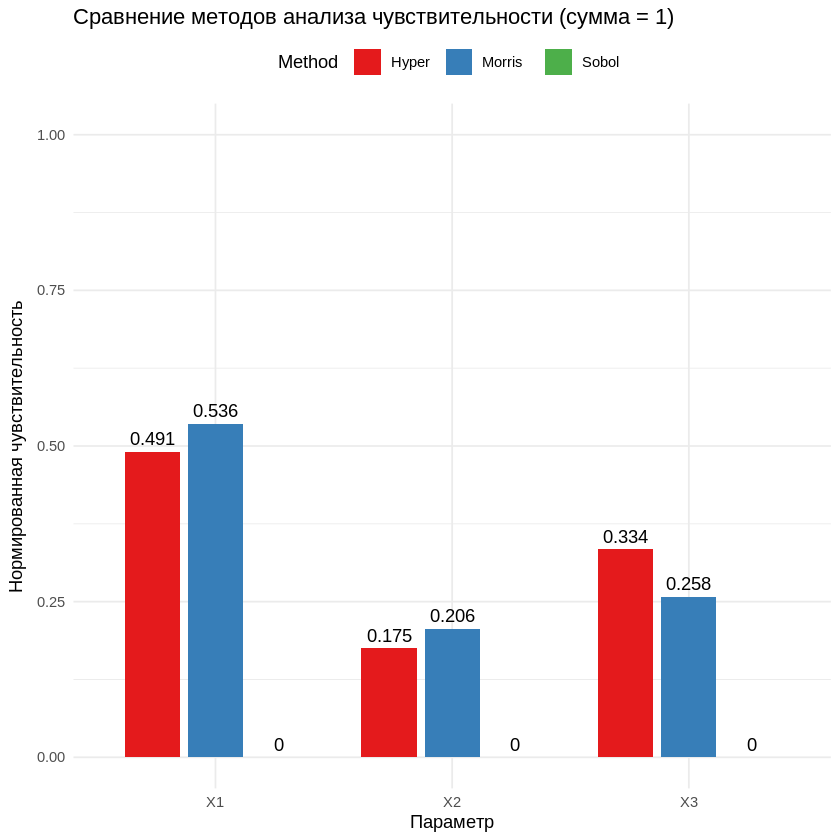

In [92]:
library(Rfast)
library(sensitivity)
library(ggplot2)
library(tidyr)



# Функция нормировки к сумме 1 (L1 норма)
normalize_to_sum1 <- function(x) {
  if (all(is.na(x)) || sum(x, na.rm = TRUE) == 0) return(x)
  x / sum(x, na.rm = TRUE)
}

# Метод Соболя с нормировкой к сумме 1
sobol_analysis <- function(f, n, x_min, x_max, N = 10) {
  # Создаем базовые матрицы A и B для плана Соболя
  A <- matrix(runif(N * n), nrow = N, ncol = n)
  B <- matrix(runif(N * n), nrow = N, ncol = n)

  # Масштабируем к заданным границам
  A_scaled <- t(apply(A, 1, function(x) x_min + x * (x_max - x_min)))
  B_scaled <- t(apply(B, 1, function(x) x_min + x * (x_max - x_min)))

  # Создаем матрицы C_i (для каждого параметра)
  C_list <- lapply(1:n, function(i) {
    C <- B
    C[, i] <- A[, i]
    t(apply(C, 1, function(x) x_min + x * (x_max - x_min)))
  })

  # Вычисляем отклики для всех точек
  y_A <- apply(A_scaled, 1, f)
  y_B <- apply(B_scaled, 1, f)
  y_C <- sapply(C_list, function(C) apply(C, 1, f))

  # Вычисляем индексы Соболя первого порядка
  total_variance <- var(c(y_A, y_B))
  S <- sapply(1:n, function(i) {
    mean(y_B * (y_C[, i] - y_A)) / total_variance
  })

  # Устранение отрицательных значений и нормировка к сумме 1
  S <- pmax(S, 0)
  normalize_to_sum1(S)
}

# Метод Морриса с нормировкой к сумме 1
morris_analysis <- function(f, n, x_min, x_max, r = 20, levels = 4) {
  morris_design <- morris(model = NULL, factors = n, r = r,
                         design = list(type = "oat", levels = levels, grid.jump = 1))
  X_morris <- t(apply(morris_design$X, 1, function(x) x_min + x * (x_max - x_min)))
  y_morris <- apply(X_morris, 1, f)
  tell(morris_design, y_morris)
  mu.star <- apply(morris_design$ee, 2, function(x) mean(abs(x)))

  # Нормировка к сумме 1
  normalize_to_sum1(mu.star)
}

# Основная функция Hyper (без изменений)
hyper_algorithm <- function(f, n, x_min, x_max, N0 = 10, max_iter = 100,
                          epsilon = 0.01, lambda = 0.7, xi = 0.1) {
  # Инициализация
  X <- generate_initial_plan(n, N0, x_min, x_max)
  f_values <- apply(X, 1, f)
  sensitivity_history <- list()

  for (iter in 1:max_iter) {
    # Шаг 2: Выбор k
    k_star <- select_optimal_k(X)

    # Шаг 3: Промежуточные точки
    intermediate_points <- find_intermediate_points(X, f_values, k_star, f)

    if (length(intermediate_points) == 0) {
      warning("Не найдено промежуточных точек на итерации ", iter)
      break
    }

    # Шаг 4: Чувствительность
    sensitivity_result <- calculate_sensitivity(intermediate_points, f, x_min, x_max)
    sensitivity_history[[iter]] <- colMeans(sensitivity_result$sensitivity)

    # Шаг 5: Генерация новых точек
    X_new <- generate_new_points(sensitivity_result$X_star,
                               sensitivity_result$sensitivity,
                               X, x_min, x_max, lambda, xi)

    if (nrow(X_new) == 0) {
      warning("Не сгенерировано новых точек на итерации ", iter)
      break
    }

    # Обновление плана
    f_new <- apply(X_new, 1, f)
    X <- rbind(X, X_new)
    f_values <- c(f_values, f_new)

    # Проверка останова
    if (iter > 1 && check_stopping_criteria(sensitivity_history, epsilon)) {
      message("Критерий останова достигнут на итерации ", iter)
      break
    }
  }

  list(X = X, f_values = f_values, sensitivity_history = sensitivity_history)
}

# Основная функция сравнения с нормировкой к сумме 1
hyper_algorithm_with_comparison <- function(f, n, x_min, x_max, N0 = 10, max_iter = 75,
                                          epsilon = 0.05, lambda = 0.9, xi = 0.1) {
  # Запуск основного алгоритма Hyper
  result <- tryCatch({
    hyper_algorithm(f, n, x_min, x_max, N0, max_iter, epsilon, lambda, xi)
  }, error = function(e) {
    message("Ошибка в алгоритме Hyper: ", e$message)
    return(NULL)
  })

  if (is.null(result)) return(list(error = "Hyper algorithm failed"))

  # Нормировка чувствительности Hyper к сумме 1
  hyper_sensitivity <- tryCatch({
    sens <- colMeans(do.call(rbind, result$sensitivity_history))
    normalize_to_sum1(sens)
  }, error = function(e) {
    message("Ошибка при расчете чувствительности Hyper: ", e$message)
    rep(NA, n)
  })

  # Запуск методов сравнения
  morris_sensitivity <- tryCatch({
    morris_analysis(f, n, x_min, x_max)
  }, error = function(e) {
    message("Ошибка в методе Морриса: ", e$message)
    rep(NA, n)
  })

  sobol_sensitivity <- tryCatch({
    sobol_analysis(f, n, x_min, x_max)
  }, error = function(e) {
    message("Ошибка в методе Соболя: ", e$message)
    rep(NA, n)
  })

  # Создаем data.frame с нормированными значениями
  comparison_df <- data.frame(
    Parameter = paste0("X", 1:n),
    Hyper = hyper_sensitivity,
    Morris = morris_sensitivity,
    Sobol = sobol_sensitivity,
    stringsAsFactors = FALSE
  )

  # Визуализация
  plot <- if(!all(is.na(hyper_sensitivity))){
    tryCatch({
      plot_sensitivity_comparison(comparison_df)
    }, error = function(e) {
      message("Ошибка при построении графика: ", e$message)
      NULL
    })
  } else NULL

  list(
    hyper_result = result,
    sensitivity_comparison = comparison_df,
    sensitivity_plot = plot
  )
}

# Функция визуализации
plot_sensitivity_comparison <- function(comparison_df) {
  long_df <- pivot_longer(comparison_df, -Parameter,
                         names_to = "Method", values_to = "Sensitivity")

  ggplot(long_df, aes(x = Parameter, y = Sensitivity, fill = Method)) +
    geom_col(position = position_dodge(width = 0.8), width = 0.7) +
    geom_text(aes(label = round(Sensitivity, 3)),
              position = position_dodge(width = 0.8), vjust = -0.5) +
    labs(title = "Сравнение методов анализа чувствительности (сумма = 1)",
         y = "Нормированная чувствительность", x = "Параметр") +
    theme_minimal() +
    theme(legend.position = "top") +
    scale_fill_brewer(palette = "Set1") +
    ylim(0, 1)
}

# Пример использования
set.seed(123)
test_function <- function(X) {
 X[1]+X[2]+3*X[1]*X[3]
}

results <- hyper_algorithm_with_comparison(
  f = test_function,
  n = 3,
  x_min = c(0, 0, 0),
  x_max = c(1, 1, 1),
  N0 = 20,
  max_iter = 30
)

# Проверка сумм
if (!is.null(results$sensitivity_comparison)) {
  cat("Суммы чувствительностей по методам:\n")
  cat("Hyper:", sum(results$sensitivity_comparison$Hyper, na.rm = TRUE), "\n")
  cat("Morris:", sum(results$sensitivity_comparison$Morris, na.rm = TRUE), "\n")
  cat("Sobol:", sum(results$sensitivity_comparison$Sobol, na.rm = TRUE), "\n")

  print(results$sensitivity_comparison)
  if (!is.null(results$sensitivity_plot)) print(results$sensitivity_plot)
}

In [80]:
install.packages("webshot")
install.packages("rgl", type = "source")  # Переустановка из исходников

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [193]:
plot_3d_points <- function(results, filename = "3d_plot.png",
                          width = 800, height = 800,
                          xlim = NULL, ylim = NULL, zlim = NULL) {
  # Устанавливаем и подключаем пакеты
  if (!requireNamespace("plot3D", quietly = TRUE)) install.packages("plot3D")
  library(plot3D)

  # Извлекаем координаты точек
  points <- results$hyper_result$X

  # Проверяем трехмерность данных
  if (ncol(points) != 3) {
    stop("Требуется матрица с 3 столбцами (X, Y, Z)")
  }

  # Автоматически определяем границы, если не заданы
  if (is.null(xlim)) xlim <- range(points[, 1])
  if (is.null(ylim)) ylim <- range(points[, 2])
  if (is.null(zlim)) zlim <- range(points[, 3])

  # Создаем PNG-файл
  png(filename, width = width, height = height)

  # Рисуем 3D-график с границами
  scatter3D(
    x = points[, 1],
    y = points[, 2],
    z = points[, 3],
    col = "blue",
    pch = 16,
    cex = 1.5,
    xlab = paste0("X1 [", xlim[1], ", ", xlim[2], "]"),
    ylab = paste0("X2 [", ylim[1], ", ", ylim[2], "]"),
    zlab = paste0("X3 [", zlim[1], ", ", zlim[2], "]"),
    xlim = xlim,
    ylim = ylim,
    zlim = zlim,
    theta = 60,
    phi = 30,
    bty = "b2",  # Куб с осями
    main = ""
  )

  dev.off()
  message("График сохранён в: ", filename)
}

In [194]:
# Тестовые данные (10 случайных точек)
set.seed(42)
results <- list(
  hyper_result = list(
    X = as.matrix(X)
))

# # Вариант 1: Автоматические границы
# plot_3d_points(results, "auto_limits.png")


plot_3d_points(results, "manual_limits.png",
              xlim = c(0, 1), ylim = c(0, 1), zlim = c(0, 1))

График сохранён в: manual_limits.png



In [55]:
install.packages("numDeriv")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [178]:
# Функция для формирования базового плана с ограничениями (Шаг 1)
generate_initial_design <- function(factor_limits, gamma = 1) {
  k <- length(factor_limits)

  # Факторные точки {-1,1}^k с учетом ограничений
  F_points <- as.matrix(expand.grid(rep(list(c(-1, 1)), k)))

  # Центральная точка {0}^k (среднее значение)
  C_point <- matrix(rep(0, k), nrow = 1)

  # Начальные дополнительные точки {±γe_i}
  S_points <- NULL
  for (i in 1:k) {
    e_i <- rep(0, k)
    e_i[i] <- 1
    S_points <- rbind(S_points, gamma * e_i, -gamma * e_i)
  }

  return(list(F = F_points, C = C_point, S = S_points, limits = factor_limits))
}

# Преобразование из нормированных значений в реальные
denormalize <- function(X_norm, limits) {
  X_real <- matrix(0, nrow = nrow(X_norm), ncol = ncol(X_norm))
  for (i in 1:ncol(X_norm)) {
    min_val <- limits[[i]][1]
    max_val <- limits[[i]][2]
    X_real[,i] <- min_val + (X_norm[,i] + 1) * (max_val - min_val) / 2
  }
  return(X_real)
}

# Преобразование из реальных значений в нормированные
normalize <- function(X_real, limits) {
  X_norm <- matrix(0, nrow = nrow(X_real), ncol = ncol(X_real))
  for (i in 1:ncol(X_real)) {
    min_val <- limits[[i]][1]
    max_val <- limits[[i]][2]
    X_norm[,i] <- 2 * (X_real[,i] - min_val) / (max_val - min_val) - 1
  }
  return(X_norm)
}

# Численное вычисление градиента с учетом ограничений
numerical_gradient <- function(f, x, limits, h = 1e-5) {
  k <- length(limits)
  grad <- numeric(k)

  # Преобразуем нормированный x в реальные значения
  x_real <- denormalize(matrix(x, nrow=1), limits)[1,]

  for (i in 1:k) {
    x_plus <- x_real
    x_minus <- x_real
    delta <- h * (limits[[i]][2] - limits[[i]][1])/2

    x_plus[i] <- min(limits[[i]][2], x_plus[i] + delta)
    x_minus[i] <- max(limits[[i]][1], x_minus[i] - delta)

    grad[i] <- (f(x_plus) - f(x_minus)) / (2 * delta)
  }
  return(grad)
}

# Функция для анализа чувствительности (Шаг 2)
sensitivity_analysis <- function(design, f) {
  # Объединяем все точки плана
  X_all_norm <- rbind(design$F, design$C, design$S)
  X_all_real <- denormalize(X_all_norm, design$limits)
  y_all <- apply(X_all_real, 1, f)

  # Индексы точек из F ∪ C и S
  n_F <- nrow(design$F)
  n_C <- nrow(design$C)
  idx_FC <- 1:(n_F + n_C)
  idx_S <- (n_F + n_C + 1):nrow(X_all_norm)

  sensitivities <- list()
  alphas <- numeric()
  X_star_points <- matrix(nrow = 0, ncol = length(design$limits))

  # Перебираем все пары (X_a, X_b)
  for (a in idx_FC) {
    for (b in idx_S) {
      X_a_norm <- X_all_norm[a,]
      X_b_norm <- X_all_norm[b,]
      X_a_real <- X_all_real[a,]
      X_b_real <- X_all_real[b,]
      y_a <- y_all[a]
      y_b <- y_all[b]

      ΔX_norm <- X_b_norm - X_a_norm
      ΔX_real <- X_b_real - X_a_real
      Δy <- y_b - y_a

      # Функция для нахождения α
      find_alpha <- function(alpha) {
        X_star_norm <- X_a_norm + alpha * ΔX_norm
        X_star_real <- denormalize(matrix(X_star_norm, nrow=1), design$limits)[1,]
        grad <- numerical_gradient(f, X_star_norm, design$limits)
        return(sum(grad * ΔX_real) - Δy)
      }

      # Проверяем значения на концах интервала
      f_lower <- find_alpha(0)
      f_upper <- find_alpha(1)

      # Если значения одного знака, используем оптимизацию вместо uniroot
      if (f_lower * f_upper > 0) {
        # Используем optimize для нахождения минимума абсолютного значения
        opt_res <- optimize(function(a) abs(find_alpha(a)), interval = c(0, 1))
        alpha_sol <- opt_res$minimum
      } else {
        # Используем uniroot если знаки разные
        alpha_sol <- uniroot(find_alpha, interval = c(0, 1))$root
      }

      X_star_norm <- X_a_norm + alpha_sol * ΔX_norm
      X_star_real <- denormalize(matrix(X_star_norm, nrow=1), design$limits)[1,]

      # Вычисляем чувствительность
      grad <- numerical_gradient(f, X_star_norm, design$limits)
      S <- abs(grad)

      # Сохраняем результаты
      sensitivities <- c(sensitivities, list(S))
      alphas <- c(alphas, alpha_sol)
      X_star_points <- rbind(X_star_points, X_star_real)
    }
  }

  return(list(
    sensitivities = sensitivities,
    alphas = alphas,
    X_star_points = X_star_points
  ))
}

# Функция для обновления точек плана (Шаг 3)
update_design <- function(design, sensitivity_result, gamma_threshold = 0.5) {
  # Находим максимальную чувствительность
  all_S <- unlist(sensitivity_result$sensitivities)
  S_max <- max(all_S)

  # Определяем порог
  S_threshold <- gamma_threshold * S_max

  # Выбираем точки с чувствительностью выше порога
  keep <- sapply(sensitivity_result$sensitivities, function(s) any(s >= S_threshold))
  S_new_real <- sensitivity_result$X_star_points[keep, , drop = FALSE]
  S_new_norm <- normalize(S_new_real, design$limits)

  # Формируем итоговый план (в нормированных значениях)
  X_final_norm <- rbind(design$F, design$C, S_new_norm)
  X_final_real <- denormalize(X_final_norm, design$limits)

  return(list(
    design_norm = X_final_norm,
    design_real = X_final_real,
    S_new = S_new_real,
    S_max = S_max,
    S_threshold = S_threshold
  ))
}


calculate_average_sensitivity <- function(sensitivity_result, k) {
  # Создаем матрицу для хранения чувствительностей по всем точкам и факторам
  sensitivity_matrix <- matrix(unlist(sensitivity_result$sensitivities),
                             ncol = k, byrow = TRUE)

  # Вычисляем среднюю чувствительность по каждому фактору
  avg_sensitivity <- colMeans(sensitivity_matrix)

  # Создаем именованный вектор для наглядности
  names(avg_sensitivity) <- paste0("X", 1:k)

  return(avg_sensitivity)
}

# Обновленный пример использования с выводом средней чувствительности
run_example <- function() {
  # Ограничения для факторов (min, max)
  factor_limits <- list(
    c(0, 1),   # X1 между 10 и 20
    c(0, 1),     # X2 между 0 и 5
    c(0, 1)     # X3 между 1 и 10
  )
  k <- length(factor_limits)

  # Ваша функция (работает с реальными значениями)
  f <- function(X) {
    return(X[1] + X[2] + 3*X[1]*X[3])
  }

  # Шаг 1: Создание начального плана
  design <- generate_initial_design(factor_limits, gamma = 0.15)

  # Шаг 2: Анализ чувствительности
  sens_result <- sensitivity_analysis(design, f)

  # Вычисляем среднюю чувствительность
  avg_sens <- calculate_average_sensitivity(sens_result, k)

  # Шаг 3: Обновление плана
  updated <- update_design(design, sens_result, 0.8)

  # Вывод результатов
  cat("\nСредняя чувствительность по факторам:\n")
  print(avg_sens)

  cat("\nМаксимальная чувствительность:", updated$S_max, "\n")
  cat("Порог чувствительности:", updated$S_threshold, "\n")
  cat("\nИтоговый план содержит", nrow(updated$design_real), "точек:\n")
  print(updated$design_real)
  return(updated$design_real)
}

# Запуск примера
X <- run_example()


Средняя чувствительность по факторам:
      X1       X2       X3 
2.503289 1.000000 1.499519 

Максимальная чувствительность: 3.3625 
Порог чувствительности: 2.69 

Итоговый план содержит 33 точек:
        [,1]   [,2]   [,3]
 [1,] 0.0000 0.0000 0.0000
 [2,] 1.0000 0.0000 0.0000
 [3,] 0.0000 1.0000 0.0000
 [4,] 1.0000 1.0000 0.0000
 [5,] 0.0000 0.0000 1.0000
 [6,] 1.0000 0.0000 1.0000
 [7,] 0.0000 1.0000 1.0000
 [8,] 1.0000 1.0000 1.0000
 [9,] 0.5000 0.5000 0.5000
[10,] 0.2875 0.2500 0.7500
[11,] 0.2125 0.2500 0.7500
[12,] 0.2500 0.2875 0.7500
[13,] 0.2500 0.2125 0.7500
[14,] 0.2500 0.2500 0.7875
[15,] 0.2500 0.2500 0.7125
[16,] 0.7875 0.2500 0.7500
[17,] 0.7125 0.2500 0.7500
[18,] 0.7500 0.2875 0.7500
[19,] 0.7500 0.2125 0.7500
[20,] 0.7500 0.2500 0.7875
[21,] 0.7500 0.2500 0.7125
[22,] 0.2875 0.7500 0.7500
[23,] 0.2125 0.7500 0.7500
[24,] 0.2500 0.7875 0.7500
[25,] 0.2500 0.7125 0.7500
[26,] 0.2500 0.7500 0.7875
[27,] 0.2500 0.7500 0.7125
[28,] 0.7875 0.7500 0.7500
[29,] 0.7125 0.750

In [179]:
X

0.0000,0.0000,0.0000
1.0000,0.0000,0.0000
0.0000,1.0000,0.0000
1.0000,1.0000,0.0000
0.0000,0.0000,1.0000
1.0000,0.0000,1.0000
0.0000,1.0000,1.0000
1.0000,1.0000,1.0000
0.5000,0.5000,0.5000
0.2875,0.2500,0.7500
0.2125,0.2500,0.7500


Warning message in morris(model = NULL, factors = k, r = n, design = morris_params):
“keeping 88 repetitions out of 100”
Ошибка в методе Соболя: invalid 'row.names' length




Сравнение методов анализа чувствительности:
  Фактор Наш_метод    Моррис Соболь_1 Соболь_2
1     X1  2.503289 1.0000000       NA       NA
2     X2  1.000000 0.3055556       NA       NA
3     X3  1.499519 0.6770833       NA       NA
$sensitivities
$sensitivities[[1]]
[1] 1.7500077 1.0000000 0.8625089

$sensitivities[[2]]
[1] 1.7500125 1.0000000 0.6375106

$sensitivities[[3]]
[1] 1.750012 1.000000 0.750012

$sensitivities[[4]]
[1] 1.7500074 1.0000000 0.7500074

$sensitivities[[5]]
[1] 1.862507 1.000000 0.750006

$sensitivities[[6]]
[1] 1.6375133 1.0000000 0.7500156

$sensitivities[[7]]
[1] 1.7500 1.0000 2.3625

$sensitivities[[8]]
[1] 1.7500 1.0000 2.1375

$sensitivities[[9]]
[1] 1.75 1.00 2.25

$sensitivities[[10]]
[1] 1.75 1.00 2.25

$sensitivities[[11]]
[1] 1.862447 1.000000 2.250046

$sensitivities[[12]]
[1] 1.637461 1.000000 2.250046

$sensitivities[[13]]
[1] 1.7500003 1.0000000 0.8625003

$sensitivities[[14]]
[1] 1.7500 1.0000 0.6375

$sensitivities[[15]]
[1] 1.7500004 1.0000000 0

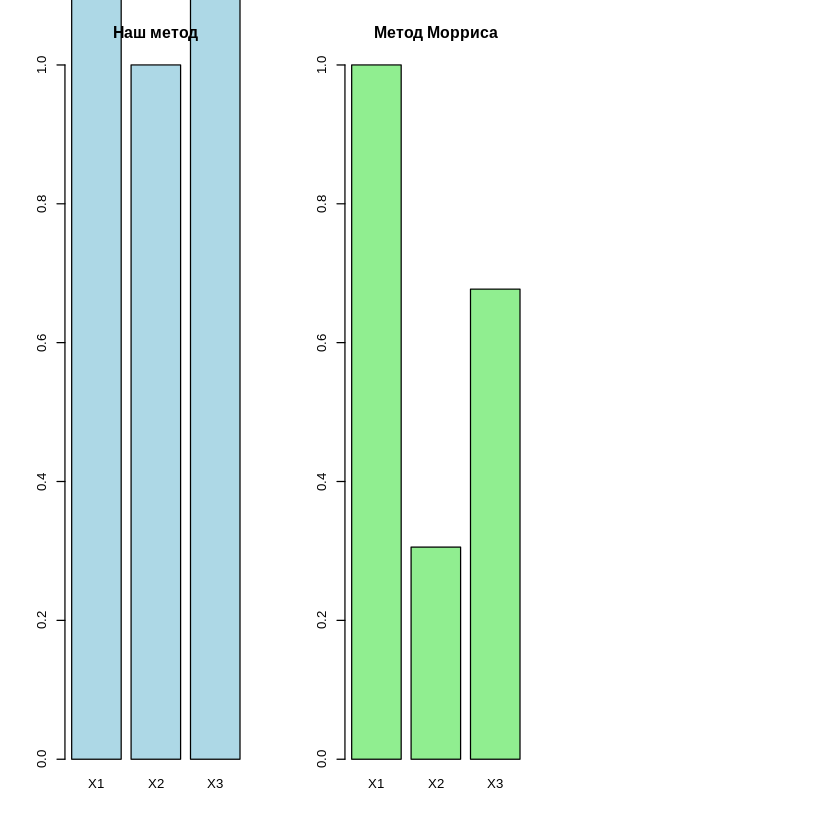

In [175]:
# Установка необходимых пакетов
if (!require("sensitivity")) install.packages("sensitivity")
library(sensitivity)

# Исправленная функция для анализа методом Морриса
morris_analysis <- function(f, factor_limits, n = 100) {
  k <- length(factor_limits)

  # Создаем матрицу параметров для метода Морриса
  morris_params <- list(
    type = "oat",
    levels = 4,
    grid.jump = 2
  )

  # Создаем план эксперимента с обработкой ошибок
  tryCatch({
    morris_design <- morris(model = NULL, factors = k, r = n,
                           design = morris_params)

    # Преобразуем нормированные значения в реальные
    X <- morris_design$X
    for (i in 1:k) {
      min_val <- factor_limits[[i]][1]
      max_val <- factor_limits[[i]][2]
      X[,i] <- min_val + (X[,i] + 1) * (max_val - min_val) / 2
    }

    # Вычисляем отклики
    responses <- apply(X, 1, f)

    # Выполняем анализ
    morris_result <- tell(morris_design, responses)
    return(morris_result)
  }, error = function(e) {
    message("Ошибка в методе Морриса: ", e$message)
    return(NULL)
  })
}

# Исправленная функция для анализа методом Соболя
sobol_analysis <- function(f, factor_limits, n = 1000) {
  k <- length(factor_limits)

  tryCatch({
    # Создаем план эксперимента по Соболю
    sobol_design <- sobol2007(model = NULL, X1 = matrix(runif(k * n), nrow = n),
                             X2 = matrix(runif(k * n), nrow = n), nboot = 100)

    # Преобразуем нормированные значения в реальные
    X <- sobol_design$X
    for (i in 1:k) {
      min_val <- factor_limits[[i]][1]
      max_val <- factor_limits[[i]][2]
      X[,i] <- min_val + X[,i] * (max_val - min_val)
    }

    # Вычисляем отклики
    responses <- apply(X, 1, f)

    # Выполняем анализ
    sobol_result <- tell(sobol_design, responses)
    return(sobol_result)
  }, error = function(e) {
    message("Ошибка в методе Соболя: ", e$message)
    return(NULL)
  })
}

# Функция для сравнения результатов с проверкой на NULL
compare_sensitivity <- function(original_result, morris_result, sobol_result, k) {
  # Результаты оригинального метода
  original_avg <- calculate_average_sensitivity(original_result, k)

  comparison <- data.frame(Фактор = paste0("X", 1:k))

  # Добавляем результаты нашего метода
  comparison$Наш_метод <- original_avg

  # Добавляем результаты Морриса, если они есть
  if (!is.null(morris_result)) {
    mu_star <- apply(abs(morris_result$ee), 2, mean)
    comparison$Моррис <- mu_star
  } else {
    comparison$Моррис <- NA
  }

  # Добавляем результаты Соболя, если они есть
  if (!is.null(sobol_result)) {
    sobol_indices <- sobol_result$S$original
    comparison$Соболь_1 <- sobol_indices[,1]  # Первый порядок
    comparison$Соболь_2 <- sobol_indices[,2]  # Общий эффект
  } else {
    comparison$Соболь_1 <- NA
    comparison$Соболь_2 <- NA
  }

  # Нормализуем значения для сравнения (если есть данные)
  if (!all(is.na(comparison$Моррис))) {
    comparison$Моррис <- comparison$Моррис / max(comparison$Моррис, na.rm = TRUE)
  }

  if (!all(is.na(comparison$Соболь_1))) {
    comparison$Соболь_1 <- comparison$Соболь_1 / max(comparison$Соболь_1, na.rm = TRUE)
    comparison$Соболь_2 <- comparison$Соболь_2 / max(comparison$Соболь_2, na.rm = TRUE)
  }

  return(comparison)
}

# Обновленный пример использования с обработкой ошибок
run_comparison_example <- function() {
  # Ограничения для факторов (min, max)
  factor_limits <- list(
    c(0, 1),   # X1 между 10 и 20
    c(0, 1),     # X2 между 0 и 5
    c(0, 1)     # X3 между 1 и 10
  )
  k <- length(factor_limits)

  # Ваша функция (работает с реальными значениями)
  f <- function(X) {
    return(X[1] + X[2] + 3*X[1]*X[3])
  }

  # 1. Наш оригинальный метод
  design <- generate_initial_design(factor_limits, gamma = 0.15)
  sens_result <- sensitivity_analysis(design, f)

  # 2. Метод Морриса
  morris_result <- morris_analysis(f, factor_limits, n = 100)

  # 3. Метод Соболя
  sobol_result <- sobol_analysis(f, factor_limits, n = 1000)

  # Сравнение результатов
  comparison <- compare_sensitivity(sens_result, morris_result, sobol_result, k)

  # Вывод результатов
  cat("\nСравнение методов анализа чувствительности:\n")
  print(comparison)

  # Визуализация (только для успешных методов)
  par(mfrow = c(1, 3))

  # График нашего метода
  barplot(comparison$Наш_метод, names.arg = comparison$Фактор,
          main = "Наш метод", ylim = c(0, 1), col = "lightblue")

  # График метода Морриса (если есть данные)
  if (!all(is.na(comparison$Моррис))) {
    barplot(comparison$Моррис, names.arg = comparison$Фактор,
            main = "Метод Морриса", ylim = c(0, 1), col = "lightgreen")
  }

  # График метода Соболя (общий эффект, если есть данные)
  if (!all(is.na(comparison$Соболь_2))) {
    barplot(comparison$Соболь_2, names.arg = comparison$Фактор,
            main = "Метод Соболя (общий)", ylim = c(0, 1), col = "lightcoral")
  }

  # Сброс параметров графики
  par(mfrow = c(1, 1))

  print(sens_result)
  print(design)
}

# Запуск примера сравнения
run_comparison_example()

In [198]:
install.packages("NeuralNetTools")
library(NeuralNetTools)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [200]:
summary(neuraldat)

       Y1               Y2               X1                 X2          
 Min.   :0.0000   Min.   :0.0000   Min.   :-4.07523   Min.   :-3.92584  
 1st Qu.:0.3742   1st Qu.:0.3576   1st Qu.:-0.64377   1st Qu.:-0.63255  
 Median :0.4641   Median :0.4469   Median : 0.04648   Median : 0.05394  
 Mean   :0.4656   Mean   :0.4477   Mean   : 0.04151   Mean   : 0.04497  
 3rd Qu.:0.5537   3rd Qu.:0.5381   3rd Qu.: 0.71727   3rd Qu.: 0.72451  
 Max.   :1.0000   Max.   :1.0000   Max.   : 3.53988   Max.   : 3.30277  
       X3          
 Min.   :-3.43596  
 1st Qu.:-0.63142  
 Median : 0.01116  
 Mean   : 0.01198  
 3rd Qu.: 0.64531  
 Max.   : 2.90699  

In [211]:
# Функция для формирования базового плана с ограничениями (Шаг 1)
generate_initial_design <- function(factor_limits, gamma = 1) {
  k <- length(factor_limits)

  # Факторные точки {-1,1}^k с учетом ограничений
  F_points <- as.matrix(expand.grid(rep(list(c(-1, 1)), k)))

  # Центральная точка {0}^k (среднее значение)
  C_point <- matrix(rep(0, k), nrow = 1)

  # Начальные дополнительные точки {±γe_i}
  S_points <- NULL
  for (i in 1:k) {
    e_i <- rep(0, k)
    e_i[i] <- 1
    S_points <- rbind(S_points, gamma * e_i, -gamma * e_i)
  }

  return(list(F = F_points, C = C_point, S = S_points, limits = factor_limits))
}

# Преобразование из нормированных значений в реальные
denormalize <- function(X_norm, limits) {
  X_real <- matrix(0, nrow = nrow(X_norm), ncol = ncol(X_norm))
  for (i in 1:ncol(X_norm)) {
    min_val <- limits[[i]][1]
    max_val <- limits[[i]][2]
    X_real[,i] <- min_val + (X_norm[,i] + 1) * (max_val - min_val) / 2
  }
  return(X_real)
}

# Преобразование из реальных значений в нормированные
normalize <- function(X_real, limits) {
  X_norm <- matrix(0, nrow = nrow(X_real), ncol = ncol(X_real))
  for (i in 1:ncol(X_real)) {
    min_val <- limits[[i]][1]
    max_val <- limits[[i]][2]
    X_norm[,i] <- 2 * (X_real[,i] - min_val) / (max_val - min_val) - 1
  }
  return(X_norm)
}

# Численное вычисление градиента с учетом ограничений
numerical_gradient <- function(f, x, limits, h = 1e-5) {
  k <- length(limits)
  grad <- numeric(k)

  # Преобразуем нормированный x в реальные значения
  x_real <- denormalize(matrix(x, nrow=1), limits)[1,]

  for (i in 1:k) {
    x_plus <- x_real
    x_minus <- x_real
    delta <- h * (limits[[i]][2] - limits[[i]][1])/2

    x_plus[i] <- min(limits[[i]][2], x_plus[i] + delta)
    x_minus[i] <- max(limits[[i]][1], x_minus[i] - delta)

    f_plus <- tryCatch(f(x_plus), error = function(e) NA)
    f_minus <- tryCatch(f(x_minus), error = function(e) NA)

    if (is.na(f_plus) || is.na(f_minus)) {
      grad[i] <- NA
    } else {
      grad[i] <- (f_plus - f_minus) / (2 * delta)
    }
  }
  return(grad)
}

# Функция для анализа чувствительности (Шаг 2)
sensitivity_analysis <- function(design, f) {
  # Объединяем все точки плана
  X_all_norm <- rbind(design$F, design$C, design$S)
  X_all_real <- denormalize(X_all_norm, design$limits)

  # Вычисляем значения функции с обработкой ошибок
  y_all <- apply(X_all_real, 1, function(x) {
    tryCatch(f(x), error = function(e) NA)
  })

  # Индексы точек из F ∪ C и S
  n_F <- nrow(design$F)
  n_C <- nrow(design$C)
  idx_FC <- 1:(n_F + n_C)
  idx_S <- (n_F + n_C + 1):nrow(X_all_norm)

  sensitivities <- list()
  alphas <- numeric()
  X_star_points <- matrix(nrow = 0, ncol = length(design$limits))

  # Перебираем все пары (X_a, X_b)
  for (a in idx_FC) {
    for (b in idx_S) {
      X_a_norm <- X_all_norm[a,]
      X_b_norm <- X_all_norm[b,]
      X_a_real <- X_all_real[a,]
      X_b_real <- X_all_real[b,]
      y_a <- y_all[a]
      y_b <- y_all[b]

      # Пропускаем если есть NA
      if (is.na(y_a)) next
      if (is.na(y_b)) next

      ΔX_norm <- X_b_norm - X_a_norm
      ΔX_real <- X_b_real - X_a_real
      Δy <- y_b - y_a

      # Функция для нахождения α с обработкой ошибок
      find_alpha <- function(alpha) {
        X_star_norm <- X_a_norm + alpha * ΔX_norm
        X_star_real <- denormalize(matrix(X_star_norm, nrow=1), design$limits)[1,]

        # Проверка на выход за границы
        if (any(is.na(X_star_real))) return(NA)

        grad <- tryCatch(
          numerical_gradient(f, X_star_norm, design$limits),
          error = function(e) NA
        )

        if (any(is.na(grad))) return(NA)

        sum(grad * ΔX_real) - Δy
      }

      # Вычисляем f_lower и f_upper с обработкой ошибок
      f_lower <- tryCatch(find_alpha(0), error = function(e) NA)
      f_upper <- tryCatch(find_alpha(1), error = function(e) NA)

      # Пропускаем если есть NA
      if (is.na(f_lower) || is.na(f_upper)) next

      # Находим alpha_sol
      if (f_lower * f_upper > 0) {
        opt_res <- tryCatch(
          optimize(function(a) abs(find_alpha(a)), interval = c(0, 1)),
          error = function(e) list(minimum = NA)
        )
        alpha_sol <- opt_res$minimum
      } else {
        alpha_sol <- tryCatch(
          uniroot(find_alpha, interval = c(0, 1))$root,
          error = function(e) NA
        )
      }

      # Пропускаем если не удалось найти alpha_sol
      if (is.na(alpha_sol)) next

      X_star_norm <- X_a_norm + alpha_sol * ΔX_norm
      X_star_real <- denormalize(matrix(X_star_norm, nrow=1), design$limits)[1,]

      # Вычисляем чувствительность
      grad <- tryCatch(
        numerical_gradient(f, X_star_norm, design$limits),
        error = function(e) rep(NA, length(design$limits))
      )

      # Пропускаем если есть NA в градиенте
      if (any(is.na(grad))) next

      S <- abs(grad)

      # Сохраняем результаты
      sensitivities <- c(sensitivities, list(S))
      alphas <- c(alphas, alpha_sol)
      X_star_points <- rbind(X_star_points, X_star_real)
    }
  }

  return(list(
    sensitivities = sensitivities,
    alphas = alphas,
    X_star_points = X_star_points
  ))
}

# Функция для обновления точек плана (Шаг 3)
update_design <- function(design, sensitivity_result, gamma_threshold = 0.25) {
  # Находим максимальную чувствительность
  all_S <- unlist(sensitivity_result$sensitivities)
  if (length(all_S) == 0) {
    warning("No valid sensitivity values found")
    return(list(
      design_norm = rbind(design$F, design$C),
      design_real = denormalize(rbind(design$F, design$C), design$limits),
      S_new = NULL,
      S_max = NA,
      S_threshold = NA
    ))
  }

  S_max <- max(all_S)

  # Определяем порог
  S_threshold <- gamma_threshold * S_max

  # Выбираем точки с чувствительностью выше порога
  keep <- sapply(sensitivity_result$sensitivities, function(s) any(s >= S_threshold))
  S_new_real <- sensitivity_result$X_star_points[keep, , drop = FALSE]
  S_new_norm <- normalize(S_new_real, design$limits)

  # Формируем итоговый план (в нормированных значениях)
  X_final_norm <- rbind(design$F, design$C, S_new_norm)
  X_final_real <- denormalize(X_final_norm, design$limits)

  return(list(
    design_norm = X_final_norm,
    design_real = X_final_real,
    S_new = S_new_real,
    S_max = S_max,
    S_threshold = S_threshold
  ))
}

# Функция для вычисления средней чувствительности
calculate_average_sensitivity <- function(sensitivity_result, k) {
  if (length(sensitivity_result$sensitivities) == 0) {
    return(rep(NA, k))
  }

  sensitivity_matrix <- matrix(unlist(sensitivity_result$sensitivities),
                             ncol = k, byrow = TRUE)

  # Вычисляем среднюю чувствительность по каждому фактору
  avg_sensitivity <- colMeans(sensitivity_matrix, na.rm = TRUE)

  # Создаем именованный вектор для наглядности
  names(avg_sensitivity) <- paste0("X", 1:k)

  return(avg_sensitivity)
}

# Функция для обучения нейронной сети
train_neural_network <- function(X, y, hidden_size = 4, epochs = 100, learning_rate = 0.01) {
  input_size <- ncol(X)
  output_size <- ncol(y)

  # Инициализация весов
  W1 <- matrix(rnorm(input_size * hidden_size), nrow = input_size, ncol = hidden_size)
  b1 <- matrix(rnorm(hidden_size), nrow = 1, ncol = hidden_size)
  W2 <- matrix(rnorm(hidden_size * output_size), nrow = hidden_size, ncol = output_size)
  b2 <- matrix(rnorm(output_size), nrow = 1, ncol = output_size)

  # Сигмоидная функция активации и её производная
  sigmoid <- function(x) 1 / (1 + exp(-x))
  sigmoid_derivative <- function(x) x * (1 - x)

  # Обучение сети
  for (epoch in 1:epochs) {
    # Прямое распространение
    hidden_input <- X %*% W1 + matrix(rep(b1, each = nrow(X)), nrow = nrow(X))
    hidden_output <- sigmoid(hidden_input)
    output <- hidden_output %*% W2 + matrix(rep(b2, each = nrow(hidden_output)), nrow = nrow(hidden_output))

    # Ошибка
    error <- y - output

    # Обратное распространение
    d_output <- error
    d_hidden <- d_output %*% t(W2) * sigmoid_derivative(hidden_output)

    # Обновление весов
    W2 <- W2 + learning_rate * t(hidden_output) %*% d_output
    b2 <- b2 + learning_rate * colSums(d_output)
    W1 <- W1 + learning_rate * t(X) %*% d_hidden
    b1 <- b1 + learning_rate * colSums(d_hidden)
  }

  return(list(W1 = W1, b1 = b1, W2 = W2, b2 = b2))
}

# Пример использования с нейронной сетью
run_nn_example <- function() {
  # Создаем тестовые данные
  set.seed(123)
  neuraldat <- data.frame(
    x1 = runif(100, 0, 1),
    x2 = runif(100, 0, 1),
    x3 = runif(100, 0, 1),
    y1 = runif(100, 0, 1)
  )

  # Подготовка данных (исправлены имена столбцов)
  X <- as.matrix(neuraldat[, c("x1", "x2", "x3")])  # Было c("X1", "X2", "X3")
  y <- as.matrix(neuraldat[, "y1", drop = FALSE])    # Было "Y1"

  # Обучение нейронной сети
  set.seed(123)
  weights <- train_neural_network(X, y, hidden_size = 4, epochs = 500)  # Увеличено число эпох

  # Функция-обертка для нейронной сети (улучшенная версия)
  nn_function <- function(X) {
    tryCatch({
      X_mat <- matrix(X, nrow = 1)
      hidden <- sigmoid(X_mat %*% weights$W1 +
                      matrix(rep(weights$b1, each = nrow(X_mat)), nrow = nrow(X_mat)))
      output <- hidden %*% weights$W2 +
               matrix(rep(weights$b2, each = nrow(hidden)), nrow = nrow(hidden))
      as.numeric(output)
    }, error = function(e) NA)
  }

  # Ограничения для факторов (используем реальные границы данных)
  factor_limits <- list(
    c(0, 1),  # X1
    c(0, 1),  # X2
    c(0, 1)   # X3
  )

  k <- length(factor_limits)

  # Шаг 1: Создание начального плана (увеличим gamma для лучшей чувствительности)
  design <- generate_initial_design(factor_limits, gamma = 0.15)  # Было 0.15

  # Шаг 2: Анализ чувствительности с дополнительной диагностикой
  cat("\nВычисление чувствительности...\n")
  sens_result <- sensitivity_analysis(design, nn_function)

  # Диагностика результатов
  if (length(sens_result$sensitivities) == 0) {
    cat("\nПредупреждение: Не удалось вычислить чувствительность. Проверьте функцию nn_function.\n")
    return(NULL)
  }

  # Вычисляем среднюю чувствительность
  avg_sens <- calculate_average_sensitivity(sens_result, k)

  # Шаг 3: Обновление плана
  updated <- update_design(design, sens_result, 0.5)  # Понижен порог для большего числа точек

  # Вывод результатов
  cat("\nСредняя чувствительность по факторам:\n")
  print(avg_sens)

  cat("\nМаксимальная чувствительность:", updated$S_max, "\n")
  cat("Порог чувствительности:", updated$S_threshold, "\n")
  cat("\nИтоговый план содержит", nrow(updated$design_real), "точек:\n")
  print(updated$design_real)

  return(list(
    design = updated$design_real,
    sensitivities = avg_sens,
    weights = weights
  ))
}

# Запускаем пример с обработкой ошибок
result <- tryCatch({
  run_nn_example()
}, error = function(e) {
  cat("Ошибка при выполнении анализа:", e$message, "\n")
  NULL
})

# Дополнительная диагностика если результат пустой
if (is.null(result)) {
  cat("\nАнализ не выполнен. Возможные причины:\n")
  cat("1. Нейронная сеть не обучается корректно\n")
  cat("2. Функция nn_function возвращает NA для всех входных значений\n")
  cat("3. Проблемы с численным вычислением градиента\n")

  # Проверка работы нейронной сети
  cat("\nПроверка работы нейронной сети на тестовых данных:\n")
  test_input <- c(0.5, 0.5, 0.5)
  test_output <- tryCatch({
    weights <- train_neural_network(
      as.matrix(neuraldat[, c("x1", "x2", "x3")]),
      as.matrix(neuraldat[, "y1", drop = FALSE]),
      hidden_size = 4, epochs = 500
    )
    nn_function(test_input)
  }, error = function(e) {
    cat("Ошибка в нейронной сети:", e$message, "\n")
    NA
  })
  cat("Вход:", test_input, "=> Выход:", test_output, "\n")
}


Вычисление чувствительности...

Средняя чувствительность по факторам:
        X1         X2         X3 
0.04084110 0.05612749 0.01184551 

Максимальная чувствительность: 0.1189395 
Порог чувствительности: 0.05946973 

Итоговый план содержит 27 точек:
           [,1]      [,2]      [,3]
 [1,] 0.0000000 0.0000000 0.0000000
 [2,] 1.0000000 0.0000000 0.0000000
 [3,] 0.0000000 1.0000000 0.0000000
 [4,] 1.0000000 1.0000000 0.0000000
 [5,] 0.0000000 0.0000000 1.0000000
 [6,] 1.0000000 0.0000000 1.0000000
 [7,] 0.0000000 1.0000000 1.0000000
 [8,] 1.0000000 1.0000000 1.0000000
 [9,] 0.5000000 0.5000000 0.5000000
[10,] 0.2575163 0.2239272 0.2239272
[11,] 0.1935419 0.2276964 0.2276964
[12,] 0.2228454 0.2562723 0.2228454
[13,] 0.2290182 0.1946654 0.2290182
[14,] 0.2258333 0.2258333 0.2597083
[15,] 0.2257807 0.2257807 0.1919136
[16,] 0.8091258 0.2245579 0.2245579
[17,] 0.7398331 0.2262321 0.2262321
[18,] 0.7777950 0.2555357 0.2222050
[19,] 0.7715008 0.1942243 0.2284992
[20,] 0.7767822 0.2232178 0.


Чувствительность по Гарсону:
    X1     X2     X3 
0.4248 0.3864 0.1888 

Средняя чувствительность по факторам (метод градиента):
    X1     X2     X3 
0.0415 0.0570 0.0120 

Максимальная чувствительность (метод градиента): 0.1332 
Порог чувствительности: 0.0666 

Итоговый план содержит 24 точек:
           [,1]      [,2]      [,3]
 [1,] 0.0000000 0.0000000 0.0000000
 [2,] 1.0000000 0.0000000 0.0000000
 [3,] 0.0000000 1.0000000 0.0000000
 [4,] 1.0000000 1.0000000 0.0000000
 [5,] 0.0000000 0.0000000 1.0000000
 [6,] 1.0000000 0.0000000 1.0000000
 [7,] 0.0000000 1.0000000 1.0000000
 [8,] 1.0000000 1.0000000 1.0000000
 [9,] 0.5000000 0.5000000 0.5000000
[10,] 0.3285852 0.2190568 0.2190568
[11,] 0.1155750 0.2311500 0.2311500
[12,] 0.2161312 0.3241968 0.2161312
[13,] 0.2371286 0.1185643 0.2371286
[14,] 0.2252877 0.2252877 0.3379315
[15,] 0.2250526 0.2250526 0.1125263
[16,] 0.6524912 0.2316725 0.2316725
[17,] 0.7604932 0.1197534 0.2395068
[18,] 0.7686408 0.2313592 0.1156796
[19,] 0.3118853 0

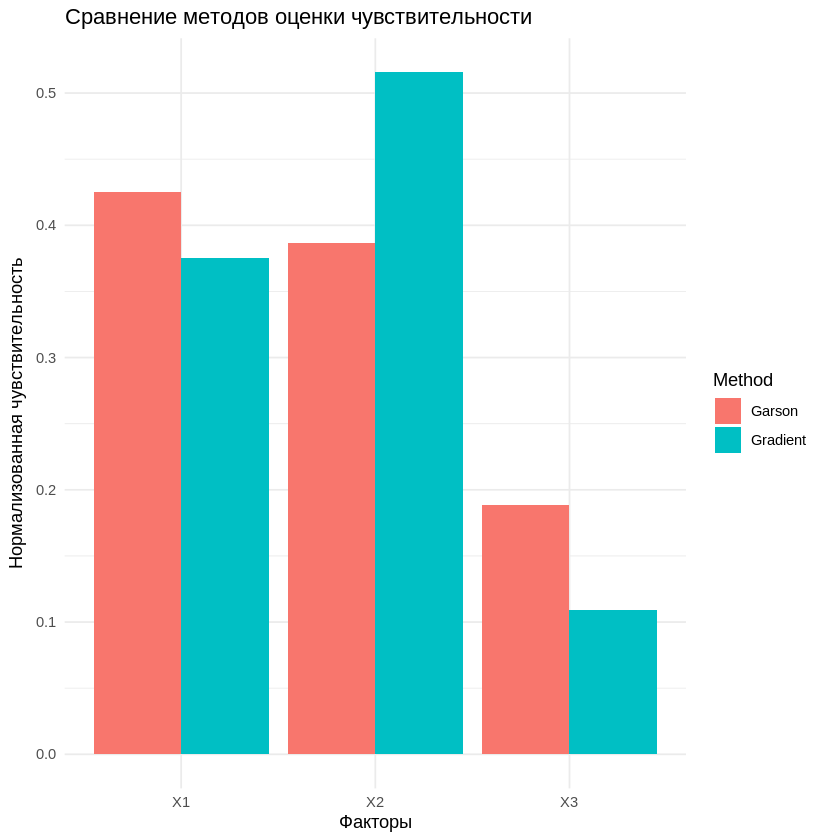

In [212]:
# Функция для вычисления чувствительности по Гарсону
garson_sensitivity <- function(weights) {
  # Получаем веса из модели
  W1 <- weights$W1
  b1 <- weights$b1
  W2 <- weights$W2
  b2 <- weights$b2

  # Количество входов и нейронов
  n_inputs <- nrow(W1)
  n_hidden <- ncol(W1)

  # Вычисляем относительную важность по Гарсону
  importance_matrix <- matrix(0, nrow = n_inputs, ncol = n_hidden)

  for (i in 1:n_inputs) {
    for (j in 1:n_hidden) {
      importance_matrix[i,j] <- abs(W1[i,j]) * abs(W2[j,1])
    }
  }

  # Нормализуем по нейронам скрытого слоя
  normalized_importance <- importance_matrix / sum(importance_matrix)

  # Суммируем по входам
  input_importance <- rowSums(normalized_importance)

  # Нормализуем до 100%
  sensitivity <- input_importance / sum(input_importance)

  # Именованный вектор
  names(sensitivity) <- paste0("X", 1:n_inputs)

  return(sensitivity)
}

# Модифицированная функция run_nn_example с добавлением метода Гарсона
run_nn_example <- function() {
  # Создаем тестовые данные
  set.seed(123)
  neuraldat <- data.frame(
    x1 = runif(100, 0, 1),
    x2 = runif(100, 0, 1),
    x3 = runif(100, 0, 1),
    y1 = runif(100, 0, 1)
  )

  # Подготовка данных
  X <- as.matrix(neuraldat[, c("x1", "x2", "x3")])
  y <- as.matrix(neuraldat[, "y1", drop = FALSE])

  # Обучение нейронной сети
  set.seed(123)
  weights <- train_neural_network(X, y, hidden_size = 4, epochs = 500)

  # Вычисляем чувствительность по Гарсону
  garson_sens <- garson_sensitivity(weights)

  # Функция-обертка для нейронной сети
  nn_function <- function(X) {
    tryCatch({
      X_mat <- matrix(X, nrow = 1)
      hidden <- sigmoid(X_mat %*% weights$W1 +
                       matrix(rep(weights$b1, each = nrow(X_mat)), nrow = nrow(X_mat)))
      output <- hidden %*% weights$W2 +
               matrix(rep(weights$b2, each = nrow(hidden)), nrow = nrow(hidden))
      as.numeric(output)
    }, error = function(e) NA)
  }

  # Ограничения для факторов
  factor_limits <- list(
    c(0, 1),  # X1
    c(0, 1),  # X2
    c(0, 1)   # X3
  )

  k <- length(factor_limits)

  # Шаг 1: Создание начального плана
  design <- generate_initial_design(factor_limits, gamma = 0.5)

  # Шаг 2: Анализ чувствительности
  sens_result <- sensitivity_analysis(design, nn_function)

  # Вычисляем среднюю чувствительность
  avg_sens <- calculate_average_sensitivity(sens_result, k)

  # Шаг 3: Обновление плана
  updated <- update_design(design, sens_result, 0.5)

  # Вывод результатов
  cat("\nЧувствительность по Гарсону:\n")
  print(round(garson_sens, 4))

  cat("\nСредняя чувствительность по факторам (метод градиента):\n")
  print(round(avg_sens, 4))

  cat("\nМаксимальная чувствительность (метод градиента):", round(updated$S_max, 4), "\n")
  cat("Порог чувствительности:", round(updated$S_threshold, 4), "\n")
  cat("\nИтоговый план содержит", nrow(updated$design_real), "точек:\n")
  print(updated$design_real)

  return(list(
    design = updated$design_real,
    sensitivities = avg_sens,
    garson_sensitivity = garson_sens,
    weights = weights
  ))
}

# Запускаем пример
result <- tryCatch({
  run_nn_example()
}, error = function(e) {
  cat("Ошибка при выполнении анализа:", e$message, "\n")
  NULL
})

# Визуализация чувствительности
if (!is.null(result)) {
  # Создаем dataframe для визуализации
  sens_df <- data.frame(
    Factor = names(result$garson_sensitivity),
    Garson = result$garson_sensitivity,
    Gradient = result$sensitivities
  )

  # Нормализуем градиентные чувствительности для сравнения
  sens_df$Gradient <- sens_df$Gradient / sum(sens_df$Gradient)

  # Преобразуем в длинный формат для ggplot
  library(tidyr)
  library(ggplot2)

  sens_long <- pivot_longer(sens_df, cols = -Factor, names_to = "Method", values_to = "Sensitivity")

  # Строим график
  ggplot(sens_long, aes(x = Factor, y = Sensitivity, fill = Method)) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(title = "Сравнение методов оценки чувствительности",
         x = "Факторы",
         y = "Нормализованная чувствительность") +
    theme_minimal()
}